In [1]:
import os
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from torchvision import transforms
from torchvision.utils import make_grid


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [12]:
! unzip '/content/drive/MyDrive/CelebA faces Dataset/archive.zip' -d'/content/CelebA faces Dataset'

Streaming output truncated to the last 5000 lines.
  inflating: /content/CelebA faces Dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: /content/CelebA faces Dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: /content/CelebA faces Dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: /content/CelebA faces Dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: /content/CelebA faces Dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: /content/CelebA faces Dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: /content/CelebA faces Dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: /content/CelebA faces Dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: /content/CelebA faces Dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: /content/CelebA faces Dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: /content/CelebA faces Dataset/img_al

In [14]:
batch_size = 128
image_size = 64
celeb_faces_data = dset.ImageFolder(
    root = "/content/CelebA faces Dataset",
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)


In [15]:
train_dl = torch.utils.data.DataLoader(
    celeb_faces_data,
    batch_size = batch_size,
    shuffle = True,
    num_workers = 2,
    drop_last = True
)

len(train_dl)

1582

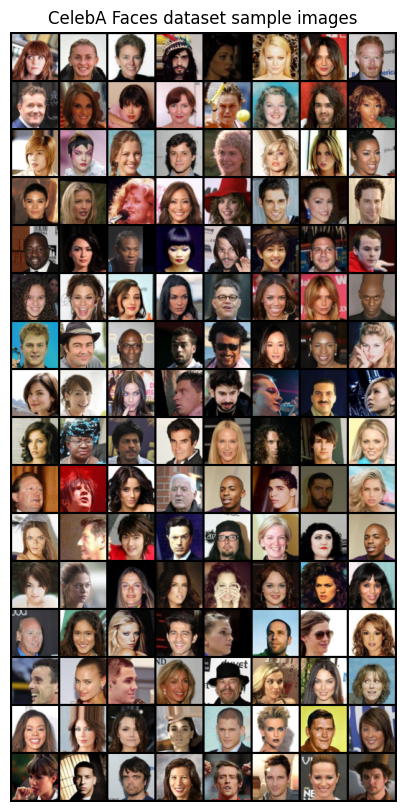

In [16]:
real_batch = next(iter(train_dl))
plt.figure(figsize = (20, 10))
plt.axis('off')

plt.title('CelebA Faces dataset sample images')
plt.imshow(np.transpose(make_grid(real_batch[0].to(device), padding = 3, normalize = True).cpu(), (1, 2, 0)))
plt.show()

In [17]:
def weights_init(m):
  classname  = m.__class__.__name__
  if classname.find('conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.2)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

Number of channels in the training images. FOr colour images the below value is 3

In [18]:
nc =3

size of z latent vector

In [19]:
nz =100

Size of feature maps in generator

In [20]:
ngf = 64

size of feature maps in Discriminator

In [21]:
ndf = 64

____________________________________________________________________________

## Generator Part

In [22]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(
            in_channels = nz,
            out_channels = ngf * 8,
            kernel_size = 4,
            stride = 1,
            padding = 0,
            bias = False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels = ngf * 8,
            out_channels = ngf * 4,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels = ngf * 4,
            out_channels = ngf * 2,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False,),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        nn.ConvTranspose2d(
            in_channels = ngf * 2,
            out_channels = ngf,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False,),
        nn.BatchNorm2d(ngf),
        nn.ReLU(True),

        nn.ConvTranspose2d(
            in_channels = ngf,
            out_channels = nc,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False,),
        nn.Tanh()
    )
  def forward(self, x):
    return self.main(x)

In [23]:
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Training Discriminator

In [24]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
        nn.Conv2d(
            in_channels = nc,
            out_channels = ndf,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(
            in_channels = ndf,
            out_channels = ndf * 2,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False),
        nn.BatchNorm2d(ndf * 2),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(
            in_channels = ndf * 2,
            out_channels = ndf * 4,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace = True),

        nn.Conv2d(
            in_channels = ndf * 4,
            out_channels = ndf * 8,
            kernel_size = 4,
            stride = 2,
            padding = 1,
            bias = True),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace = True),
        nn.Conv2d(
            in_channels = ndf * 8,
            out_channels = 1,
            kernel_size = 4,
            stride = 1,
            padding = 0,
            bias = False),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.main(x)


In [25]:
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Initializing the BCELoss function

In [26]:
criterion = nn.BCELoss()

In [27]:
## Creating a batch of latent vectors for visualizing the progress of generator

fixed_noise = torch.randn(64, nz, 1, 1, device = device)


In [28]:
real_image_labels = torch.full((batch_size,), 1., dtype = torch.float, device = device)
fake_image_labels = torch.full((batch_size,), 0., dtype = torch.float, device = device)

In [29]:
## setup adam optimizers for both generator and discriminator

In [30]:
optimizer_d = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizer_g = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.5, 0.999))

## Utility function to display a grid of images during the training

In [31]:
def display(img):
  plt.figure(figsize = (5,5))
  img = img / 2 + 0.5
  img  = img.permute(1, 2, 0)
  npimg = img.numpy()
  plt.imshow(npimg)
  plt.xticks([])
  plt.yticks([])
  plt.show()

## training the model

  0%|          | 0/10 [00:00<?, ?it/s]

----------------------------
          Epoch 1: step: 0 | Discriminator Loss: 0.3692 | Generator Loss: 3.3951
            


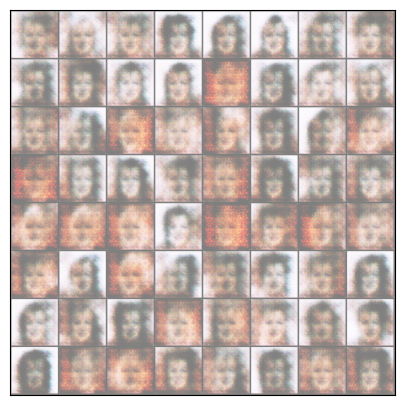

In [ ]:
G_losses = []
D_losses = []

num_epochs = 10

real_Score_list = []
fake_Score_list = []

for epochs in tqdm(range(num_epochs)):
  for i, (data, _) in enumerate(train_dl, 0):

    netD.zero_grad()
    real_images = data.to(device)
    output = netD(real_images).view(-1)
    real_loss_D = criterion(output, real_image_labels)
    real_loss_D.backward()
    real_score_D = output.mean().item()
    noise = torch.randn(batch_size, nz, 1, 1, device = device)
    fake_images = netG(noise)
    output = netD(fake_images.detach()).view(-1)
    fake_loss_D = criterion(output, fake_image_labels)
    fake_loss_D.backward()
    fake_score_D = output.mean().item()
    total_loss_D = real_loss_D + fake_loss_D
    optimizer_d.step()

    netG.zero_grad()
    output = netD(fake_images).view(-1)
    loss_G = criterion(output, real_image_labels)
    loss_G.backward()
    optimizer_g.step()

    if i % 200 ==0 or ((epochs == num_epochs - 1) and (i == len(train_dl) - 1)):
      print(f"""----------------------------
          Epoch {epochs + 1}: step: {i} | Discriminator Loss: {total_loss_D.item():.4f} | Generator Loss: {loss_G.item():.4f}
            """)
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
        display(make_grid(fake, padding = 2, normalize = True))
    G_losses.append(loss_G.item())
    D_losses.append(total_loss_D.item())
    real_Score_list.append(real_score_D)
    fake_Score_list.append(fake_score_D)
